In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from ydata_profiling import ProfileReport
from pathlib import Path
%matplotlib inline


In [2]:
data_dir = Path("c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/planning_extract_core_parts")
csv_files = data_dir.glob("*.csv")

df = pd.concat(
    (pd.read_csv(f) for f in csv_files),
    ignore_index=True
)

In [3]:
df_sample = df.sample(n=50_000, random_state=42)

cols_to_drop = [
    "decision_date",
    "valid_date",
    "received_date",
    "lapsed_date",
    "last_updated"
]

df_profile = df_sample.drop(columns=[c for c in cols_to_drop if c in df_sample.columns])


from ydata_profiling import ProfileReport

profile = ProfileReport(
    df_profile,
    title="API Data (Profiling subset)",
    explorative=True
)

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df['valid_date'] = pd.to_datetime(
    df['valid_date'],
    errors='coerce',
    dayfirst=True
)

df['decision_date'] = pd.to_datetime(
    df['decision_date'],
    errors='coerce',
    dayfirst=True
)



In [5]:
df_decided = df.loc[df['decision_date'].notna()].copy()


In [6]:
df_decided['decision_time_days'] = (
    df_decided['decision_date'] - df_decided['valid_date']
).dt.days
df_decided = df_decided.loc[
    df_decided['decision_time_days'] >= 0
]


In [7]:
approved_labels = ['Approved', 'Approved with Conditions']

df_decided['approved'] = df_decided['decision'].isin(approved_labels).astype(int)


In [8]:
df_decided['year_month'] = df_decided['decision_date'].dt.to_period('M')


In [9]:
panel = (
    df_decided
    .groupby(['lpa_name', 'year_month'])
    .agg(
        median_decision_time=('decision_time_days', 'median'),
        approval_rate=('approved', 'mean'),
        decision_volume=('approved', 'size')
    )
    .reset_index()
)


In [10]:
panel['year_month'] = panel['year_month'].dt.to_timestamp()


In [11]:
train = panel.loc[panel['year_month'] < '2025-01-01'].copy()
test  = panel.loc[panel['year_month'] >= '2025-01-01'].copy()


In [12]:
print(train['lpa_name'].nunique())
print(test['lpa_name'].nunique())

print(train['year_month'].min(), train['year_month'].max())
print(test['year_month'].min(), test['year_month'].max())


33
33
2010-01-01 00:00:00 2024-12-01 00:00:00
2025-01-01 00:00:00 2026-01-01 00:00:00


In [13]:
panel.to_csv("c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/borough_month_panel.csv", index=False)


In [14]:
import pandas as pd

borough_month_panel = pd.read_csv(
    "c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/borough_month_panel.csv",
    parse_dates=["year_month"]
)


In [15]:
borough_month_panel.info()
borough_month_panel.describe()
borough_month_panel.isna().mean()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4487 entries, 0 to 4486
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   lpa_name              4487 non-null   object        
 1   year_month            4487 non-null   datetime64[ns]
 2   median_decision_time  4487 non-null   float64       
 3   approval_rate         4487 non-null   float64       
 4   decision_volume       4487 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 175.4+ KB


lpa_name                0.0
year_month              0.0
median_decision_time    0.0
approval_rate           0.0
decision_volume         0.0
dtype: float64

In [16]:
borough_month_panel.to_csv(
    "c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/processed/borough_month_panel.csv",
    index=False
)


In [17]:
bmp = borough_month_panel.copy()


In [18]:
train_mask = bmp['year_month'] < '2025-01-01'

p90_volume = (
    bmp.loc[train_mask]
    .groupby('lpa_name')['decision_volume']
    .quantile(0.9)
    .rename('p90_volume')
)


In [19]:
bmp = bmp.merge(p90_volume, on='lpa_name', how='left')


In [20]:
bmp['shock_flag'] = (bmp['decision_volume'] > bmp['p90_volume']).astype(int)


In [21]:
bmp['shock_intensity'] = bmp['decision_volume'] / bmp['p90_volume']


In [22]:
bmp['shock_flag'].mean()


0.10140405616224649

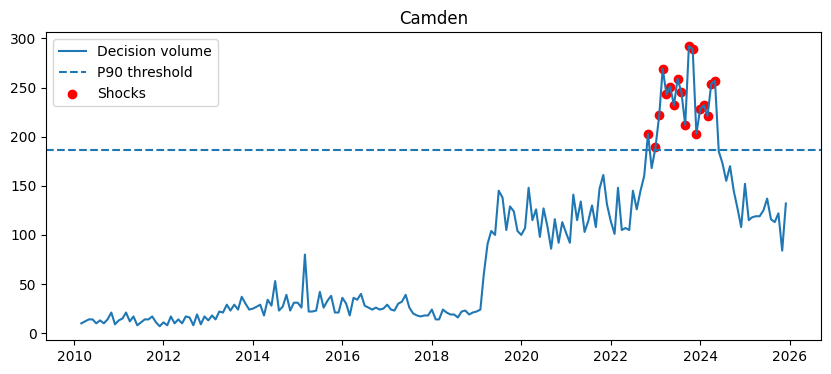

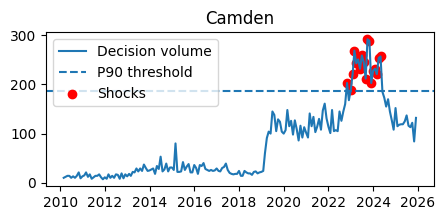

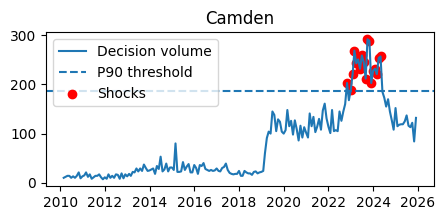

In [26]:
import matplotlib.pyplot as plt

b = "Camden"

sub = bmp[bmp['lpa_name'] == b]

plt.figure(figsize=(5,2))
plt.plot(sub['year_month'], sub['decision_volume'], label='Decision volume')
plt.axhline(sub['p90_volume'].iloc[0], linestyle='--', label='P90 threshold')
plt.scatter(
    sub.loc[sub['shock_flag'] == 1, 'year_month'],
    sub.loc[sub['shock_flag'] == 1, 'decision_volume'],
    color='red', label='Shocks'
)
plt.legend()
plt.title(b)
plt.show()


In [30]:
borough_month_panel_shocks = bmp.copy()
borough_month_panel_shocks.to_csv(
    "c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/processed/borough_month_panel_with_shocks.csv",
    index=False
)


In [31]:
bmp = borough_month_panel_shocks.copy()

train_mask = bmp['year_month'] < '2025-01-01'
non_shock = bmp['shock_flag'] == 0

baseline = (
    bmp.loc[train_mask & non_shock]
    .groupby('lpa_name')
    .agg(
        baseline_mdt=('median_decision_time', 'median'),
        baseline_ar=('approval_rate', 'median')
    )
    .reset_index()
)

bmp = bmp.merge(baseline, on='lpa_name', how='left')


In [32]:
bmp['impact_mdt'] = (
    bmp['median_decision_time'] - bmp['baseline_mdt']
)

bmp['impact_ar'] = (
    bmp['baseline_ar'] - bmp['approval_rate']
)


In [33]:
bmp[['impact_mdt', 'impact_ar']].describe()


impact_mdt    impact_ar
count  4487.000000  4487.000000
mean     10.138066     0.032384
std      59.583568     0.183079
min     -56.000000    -0.545045
25%      -2.000000    -0.046562
50%       0.000000     0.000933
75%       1.500000     0.067532
max    1416.000000     1.000000

In [34]:
bmp['shock_month'] = bmp['shock_flag'] == 1


In [35]:
bmp.to_csv(
    "c:/Users/Jose Miguel/OneDrive/Ambiente de Trabalho/NOVA/TESE/processed/borough_month_panel_resilience_inputs.csv",
    index=False
)
